In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
# Any results you write to the current directory are saved as output.

# Loading and Preparing Dataset

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class MNIST_Dataset(Dataset):
    
    def __init__(self, X, y, transform = transforms.Compose(
                     [transforms.ToPILImage(), 
                      transforms.ToTensor(), 
                      transforms.Normalize(mean=(0.5,), std=(0.5,))])):
            
        self.transform = transform
        self.X = X.reshape((-1,64,64)).astype(np.uint8)[:,:,:,None]
        self.y = y
        
    @classmethod
    def from_train(cls, file_path_images, file_path_labels):
        train_images = pd.read_pickle(file_path_images)
        train_labels = pd.read_csv(file_path_labels)
        
#         one_hot_encoded_labels = pd.get_dummies(train_labels['Category']).values # Is one hot encoding necessary??
        return cls(X=train_images, y=torch.from_numpy(train_labels['Category'].values))
        
    @classmethod
    def from_test(cls, file_path_images):
        test_images = pd.read_pickle(file_path_images)
        
        return cls(X=test_images, y=None)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.transform(self.X[idx])
        X = X.to(device)
        if self.y is not None:
            return X, self.y[idx].to(device)
        else:
            return X

In [3]:
batch_size = 64

train_dataset = MNIST_Dataset.from_train('../input/train_images.pkl', '../input/train_labels.csv')
test_dataset = MNIST_Dataset.from_test('../input/test_images.pkl')

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)

# Neural Network Architecture, and Optimizer, and Loss Functions

In [4]:
class ConvNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 4),
            nn.ReLU(),
            nn.Conv2d(64, 64, 4),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, 5),
            nn.ReLU(),
            nn.Conv2d(64, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2))
        self.fc = nn.Linear(256, output_dim)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

input_dim = 64 * 64
output_dim = 10
conv_net = ConvNet(input_dim, output_dim).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net.parameters(), lr=1e-3)

# Training Loop

In [5]:
losses_per_epoch = []
for epoch in range(50):
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.to(dtype=torch.long)
        optimizer.zero_grad()
        
        outputs = conv_net(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    print('[%d] Loss: %.3f' % (epoch + 1, loss))
    losses_per_epoch.append(loss)
print('Finished Training')

[1] Loss: 1.320
[2] Loss: 0.643
[3] Loss: 0.577
[4] Loss: 0.345
[5] Loss: 0.211
[6] Loss: 0.387
[7] Loss: 0.254
[8] Loss: 0.373
[9] Loss: 0.327
[10] Loss: 0.286
[11] Loss: 0.115
[12] Loss: 0.225
[13] Loss: 0.180
[14] Loss: 0.499
[15] Loss: 0.092
[16] Loss: 0.214
[17] Loss: 0.043
[18] Loss: 0.245
[19] Loss: 0.097
[20] Loss: 0.096
[21] Loss: 0.064
[22] Loss: 0.008
[23] Loss: 0.033
[24] Loss: 0.043
[25] Loss: 0.105
[26] Loss: 0.058
[27] Loss: 0.158
[28] Loss: 0.121
[29] Loss: 0.086
[30] Loss: 0.239
[31] Loss: 0.206
[32] Loss: 0.039
[33] Loss: 0.119
[34] Loss: 0.078
[35] Loss: 0.100
[36] Loss: 0.053
[37] Loss: 0.096
[38] Loss: 0.049
[39] Loss: 0.057
[40] Loss: 0.019
[41] Loss: 0.051
[42] Loss: 0.166
[43] Loss: 0.031
[44] Loss: 0.108
[45] Loss: 0.046
[46] Loss: 0.140
[47] Loss: 0.090
[48] Loss: 0.018
[49] Loss: 0.028
[50] Loss: 0.040
Finished Training


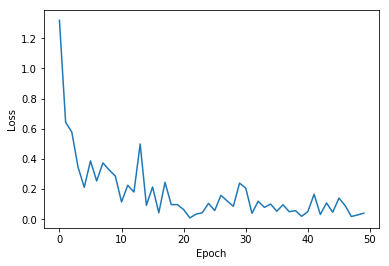

In [6]:
plt.plot(losses_per_epoch)
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.show();

In [7]:
def predict(data_loader):
    conv_net.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        output = conv_net(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [8]:
test_predictions = predict(test_loader)
test_predictions = test_predictions.numpy()

In [9]:
d = {'Id' : [x for x in range(0, len(test_predictions))], 'Category' : test_predictions.flatten().tolist()}
submission = pd.DataFrame(d)
submission.to_csv(path_or_buf='submission.csv', index=False)